# Computer Vision: Assignment 1

### Importing libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import random
%matplotlib inline

## Visualizing the images

Shape image 1 :  (500, 700, 3)
Shape image 2 :  (500, 700, 3)


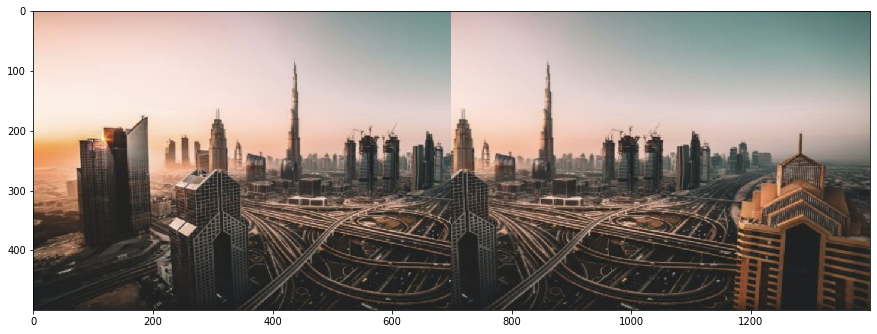

In [16]:
# Path to the image
path1 = 'IMG_1.jpg'
path2 = 'IMG_2.jpg'

# Resize params (if necessary)
resizeX = 700
resizeY = 500

# Loading the images
img_loader1 = cv2.imread(path1)
img_loader2 = cv2.imread(path2)

img_loader1 = cv2.resize(img_loader1, (resizeX, resizeY))
img_loader2 = cv2.resize(img_loader2, (resizeX, resizeY))
print('Shape image 1 : ', np.shape(img_loader1))
print('Shape image 2 : ', np.shape(img_loader2))

# Concatenate both images for the visualisation
horizontal_img = np.concatenate((img_loader1, img_loader2), axis=1)

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
# Show as RGB!
ax.imshow(cv2.cvtColor(horizontal_img, cv2.COLOR_BGR2RGB), interpolation='nearest')
plt.show()

# Harris Corner Detection

In [3]:
def compute_harris_point(imgA, imgB, plot = True):
    graysc1 = np.float32(cv2.cvtColor(imgA, cv2.COLOR_BGR2GRAY))
    graysc2 = np.float32(cv2.cvtColor(imgB, cv2.COLOR_BGR2GRAY))

    feature_points1 = cv2.cornerHarris(graysc1, 5, 3, 0.01)
    feature_points2 = cv2.cornerHarris(graysc2, 5, 3, 0.01)
    max1 = feature_points1.max()
    max2 = feature_points2.max()
    threshold1 = max1 * 0.1
    threshold2 = max2 * 0.1
    # First Image
    for x in range(len(imgA)):
        for y in range(len(imgA[0])):
            if feature_points1[x, y] > threshold1:
                imgA = cv2.circle(imgA, (y, x) , 5, (0, 0, 255), 1)

    for x in range(len(imgB)):
        for y in range(len(imgB[0])):
            if feature_points2[x, y] > threshold2:
                imgB = cv2.circle(imgB, (y, x) , 5, (255, 255, 0), 1)  
    horizontal_img = np.concatenate((imgA, imgB), axis=1)
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111)
    # Show as RGB!
    ax.imshow(cv2.cvtColor(horizontal_img, cv2.COLOR_BGR2RGB), interpolation='nearest')
    plt.savefig('corner_harris.png')
    #files.download("corner_harris.png") 
    plt.show()


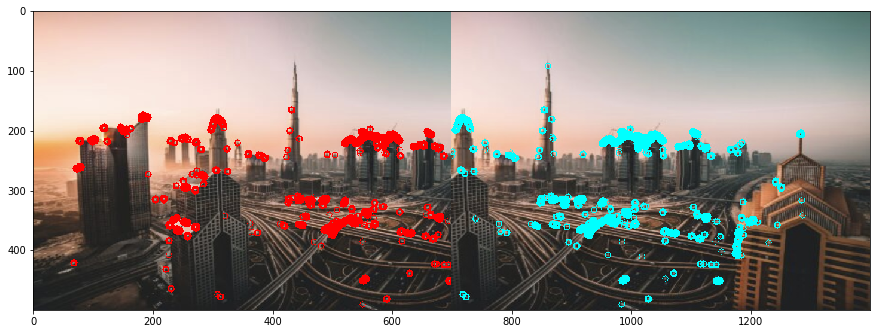

In [4]:
compute_harris_point(img_loader1, img_loader2)

# Scale-Invariant Feature Transform (SIFT)

In [5]:
def sift(img):
    img_bw = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    # Find feature points in image
    feature_points, descriptors = sift.detectAndCompute(img_bw,None)
    # Draw points on image
    img_sift = cv2.drawKeypoints(img_bw,feature_points,img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return img_sift, feature_points, descriptors

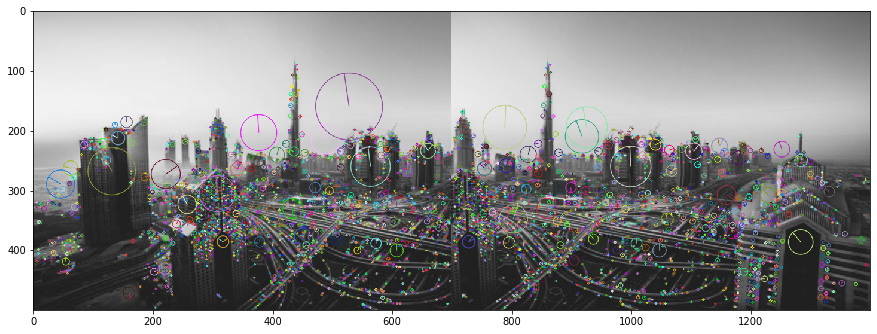

In [6]:
# Loads images again
img_loader1 = cv2.imread(path1)
img_loader2 = cv2.imread(path2)
img_loader1 = cv2.resize(img_loader1, (resizeX, resizeY))
img_loader2 = cv2.resize(img_loader2, (resizeX, resizeY))

!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17


sift_img1, fp1, descriptors1 = sift(img_loader1)
sift_img2, fp2, descriptors2 = sift(img_loader2)

horizontal_img = np.concatenate((sift_img1, sift_img2), axis=1)

# Plot sift feature points
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
ax.imshow(horizontal_img, interpolation='nearest')
plt.show()

In [7]:
print('Shape Descriptors img 1 (Number of descriptors, Dimension of Descriptor): ', np.shape(descriptors1))
print('Shape Descriptors img 2 (Number of descriptors, Dimension of Descriptor): ', np.shape(descriptors2))

Shape Descriptors img 1 (Number of descriptors, Dimension of Descriptor):  (2467, 128)
Shape Descriptors img 2 (Number of descriptors, Dimension of Descriptor):  (2316, 128)


# Descriptor Matching
Now that we have our descriptors for each image, we can compute the distance between each pair of descriptor (from image 1 and image 2), and try to find pairs of descriptor which have a short distance.

In [8]:
# Brute Force Matching
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1,descriptors2, k=2)

print(len(matches))
# Apply ratio test
valid = []
threshold = 0.2
for m,n in matches:
  if m.distance < threshold*n.distance:
    valid.append([m])

valid_matches = []
for match in valid:
    valid_matches.append(list(fp1[match[0].queryIdx].pt + fp2[match[0].trainIdx].pt))

valid_matches = np.array(valid_matches)
print('Number of matches before thresholding : ', np.shape(matches))
print('Number of matches after thresholding : ', np.shape(valid_matches))

2467
Number of matches before thresholding :  (2467, 2)
Number of matches after thresholding :  (350, 4)


Let's draw the matches that are below our threshold

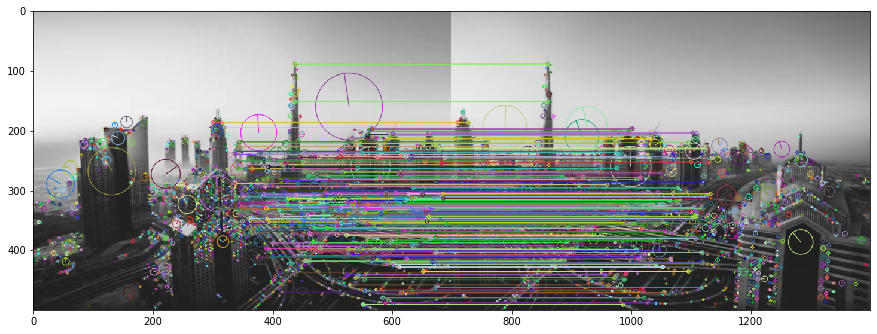

In [9]:
image_matching = cv2.drawMatchesKnn(img_loader1,fp1,img_loader2,fp2, valid, outImg = None , flags=2)

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
ax.imshow(image_matching, interpolation='nearest')
plt.show()

In [10]:
# @https://ros-developer.com/2017/12/26/finding-homography-matrix-using-singular-value-decomposition-and-ransac-in-opencv-and-matlab/
def homography_matrix(match):
    mat = []
    for i in range(len(match)):
        desc1 = np.append(match[i][0:2], 1)
        desc2 = np.append(match[i][2:4], 1)
        row1 = [0, 0, 0, desc1[0], desc1[1], desc1[2], -desc2[1]*desc1[0], -desc2[1]*desc1[1], -desc2[1]*desc1[2]]
        row2 = [desc1[0], desc1[1], desc1[2], 0, 0, 0, -desc2[0]*desc1[0], -desc2[0]*desc1[1], -desc2[0]*desc1[2]]
        mat.append(row1)
        mat.append(row2)
    control_matrix = np.array(mat)
    _, _, V = np.linalg.svd(control_matrix)
    H = V[-1].reshape(3, 3)
    H = H/H[2, 2] 
    return H

# RANSAC ALGORITHM

In [11]:
def ransac(n_iter, valid_matches, points_of_interest= 4):
    N_max_inlier = 0 
    threshold = 0.2
    print(len(valid_matches))
    for iter in range(n_iter):
      # Select random indices (3 in total)
      indices = random.sample(range(len(valid_matches)), points_of_interest)
      # Retrieve point that corresponds to the match at the given indices
      match = np.array([valid_matches[i] for i in indices])
      #H, s = cv2.findHomography(rnd_pairs1, rnd_pairs2, cv2.RANSAC, 5.0)
      #print(H)
      H = homography_matrix(match)

      # Point from first image
      points_image1 = np.concatenate((valid_matches[:, 0:2], np.ones((len(valid_matches), 1))), axis=1)
      # Point from second image
      points_image2 = valid_matches[:, 2:4]

      model_estimation = np.zeros((len(valid_matches), 2))
      # Fit the model (fit the point form image one to the model (dot product with the 
      # Homogeneous matrix, and then compute the inverse transform (on the second image points) to retrieve the error))
      for i in range(len(valid_matches)):
              fit = np.dot(H, points_image1[i])
              model_estimation[i] = (fit/fit[2])[0:2]  
      # Compute error (inverse transform)  
      errors = np.linalg.norm(points_image2 - model_estimation , axis=1) ** 2 
      # Retrieve inliers given index where the error is lower than the threshold
      inliers = valid_matches[np.where(errors < threshold)[0]]
      count_inliers = len(inliers)
      if count_inliers > N_max_inlier:
            N_max_inlier = count_inliers
            inliers_copy = inliers
            H_copy = H
    return inliers_copy, H_copy        

In [12]:
def is_black_pixel(pix1):
    return pix1[0] == 0 and pix1[1] == 0 and pix1[2] == 0

In [13]:
def stitch(image1, image2, H):   
    # Normalize the images 
    image1 = image1/255
    image2 = image2/255                         

    # Corners of the original left image
    corners = [[0, 0, 1], [image1.shape[1], 0, 1], [image1.shape[1], image1.shape[0], 1], [0, image1.shape[0], 1]]

    # Corners of the image after tranformation / Store in a 3x4 matrix
    new_cor = np.array([np.dot(H, corner) for corner in corners]).T

    new_x_coord = new_cor[0] 
    new_y_coord = new_cor[1] 

    control_matrix = np.array([[1, 0, -(new_x_coord[0])], [0, 1, -(new_y_coord[0])], [0, 0, 1]])
    
    height_new = int(abs(new_y_coord[0]) + image1.shape[0])
    width_new = int(abs(new_x_coord[0]) + image1.shape[1])
    
    # Homogenous matrix applied on corner points
    H = np.dot(control_matrix, H)

    # right image
    warped_im1 = cv2.warpPerspective(image1, H, dsize= (width_new, height_new))

    height_new = int(abs(new_y_coord[0]) + image2.shape[0])
    width_new = int(abs(new_x_coord[0]) + image2.shape[1])    

    warped_im2 = cv2.warpPerspective(image2, control_matrix, (width_new, height_new)) 

    # Stitches pixels together    
    for i in range(warped_im2.shape[0]):
        for j in range(warped_im2.shape[1]):
            left_im_p = warped_im1[i, j, :]
            right_im_p = warped_im2[i, j, :]
            if not is_black_pixel(left_im_p) and is_black_pixel(right_im_p):
                warped_im1[i, j, :] = left_im_p
            elif is_black_pixel(left_im_p) and not is_black_pixel(right_im_p):
                warped_im1[i, j, :] = right_im_p
            # take mean intensity of both pixel if they are both there    
            elif not is_black_pixel(left_im_p) and not is_black_pixel(right_im_p):
                warped_im1[i, j, :] = (left_im_p + right_im_p) / 2
            else:
                pass
    # Restricts size               
    final_image = warped_im1[:warped_im2.shape[0], :warped_im2.shape[1], :]
    return final_image

350
343


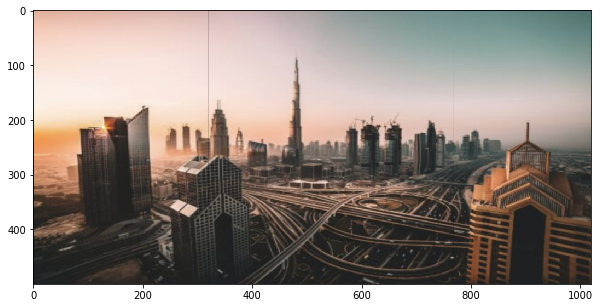

In [14]:
left_image = cv2.imread(path1)
right_image = cv2.imread(path2)
left_image = cv2.resize(left_image, (resizeX, resizeY))
right_image = cv2.resize(right_image, (resizeX, resizeY))
# Ransac 
inliers, H  = ransac(10000, valid_matches)
print(len(inliers))
# Given two images and the Homogeneous matrix, stitch the two images together
image_stitched = stitch(left_image, right_image, H)
fig = plt.figure(figsize=(10, 15))
ax = fig.add_subplot(111)
ax.imshow(image_stitched[:,:,::-1], interpolation='nearest')
plt.show()